Fruit Prices Data:
                        Fruit    Form  RetailPrice RetailPriceUnit  Yield  \
0                      Apples   Fresh       1.8541       per pound   0.90   
1          Apples, applesauce  Canned       1.1705       per pound   1.00   
2      Apples, ready-to-drink   Juice       0.8699        per pint   1.00   
3  Apples, frozen concentrate   Juice       0.6086        per pint   1.00   
4                    Apricots   Fresh       3.6162       per pound   0.93   

   CupEquivalentSize CupEquivalentUnit  CupEquivalentPrice  
0             0.2425            pounds              0.4996  
1             0.5401            pounds              0.6323  
2             8.0000      fluid ounces              0.4349  
3             8.0000      fluid ounces              0.3043  
4             0.3638            pounds              1.4145  

Vegetable Prices Data:
      Vegetable    Form  RetailPrice RetailPriceUnit   Yield  \
0  Acorn squash   Fresh       1.2136       per pound  0.4586   


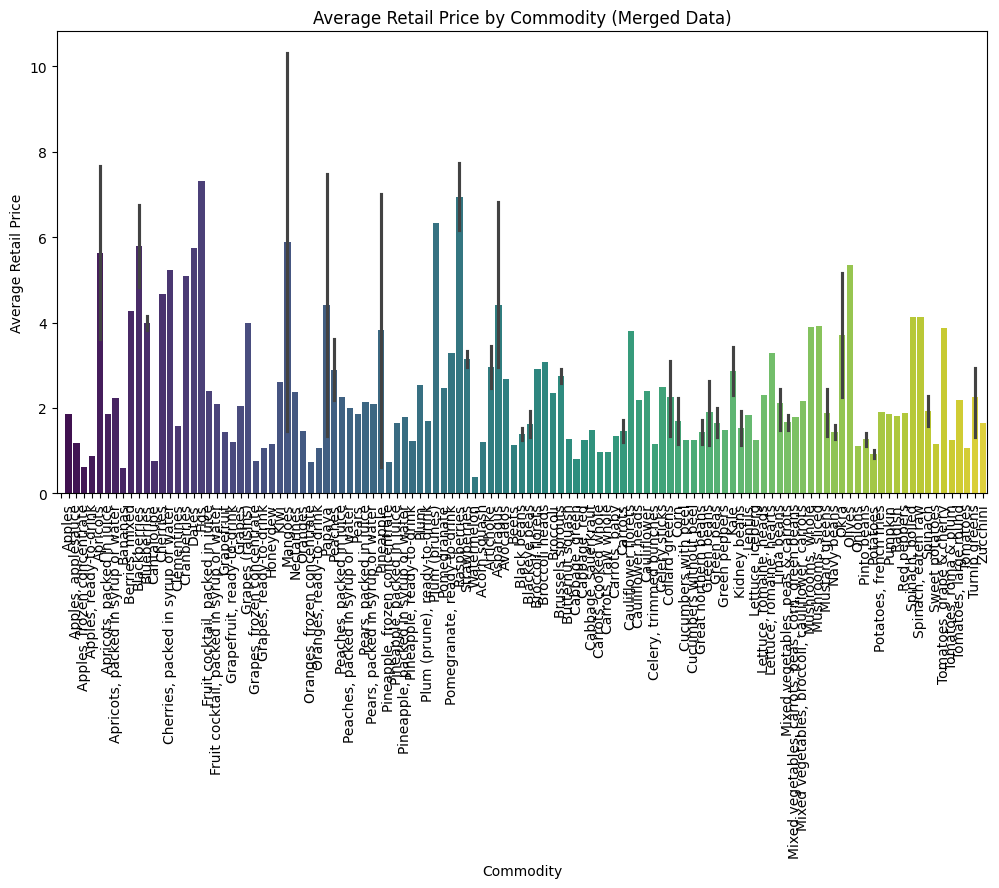

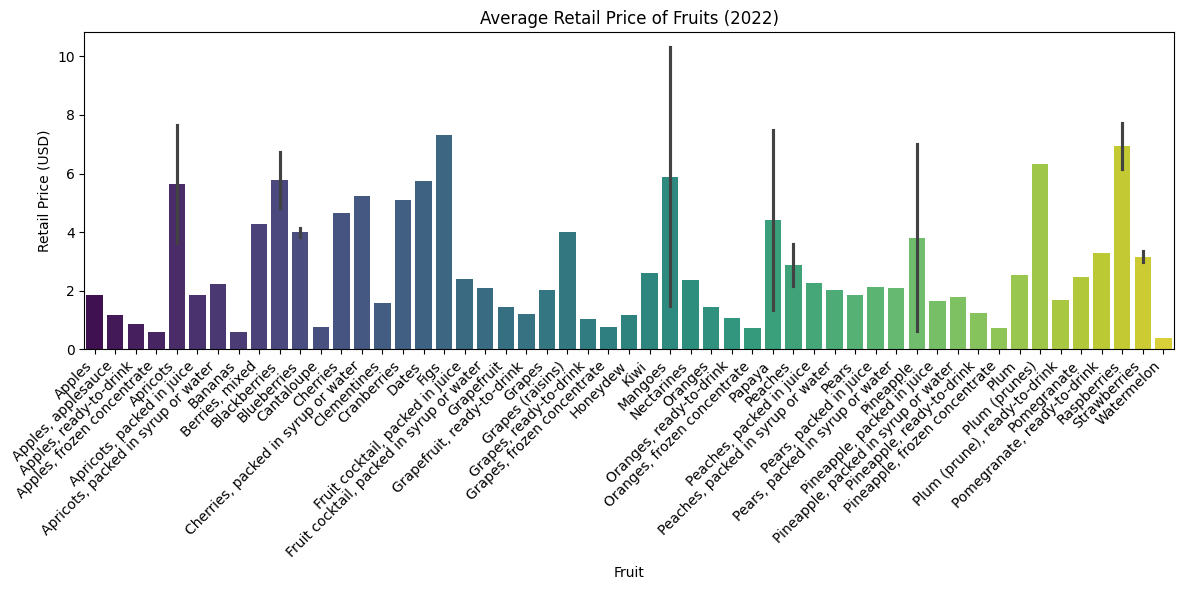

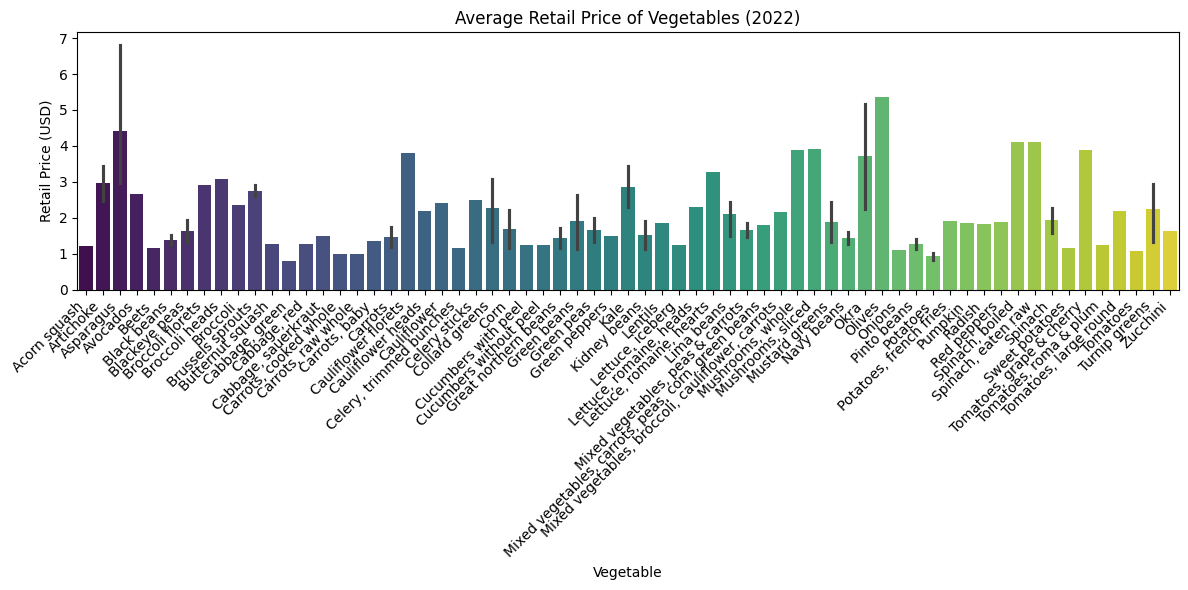

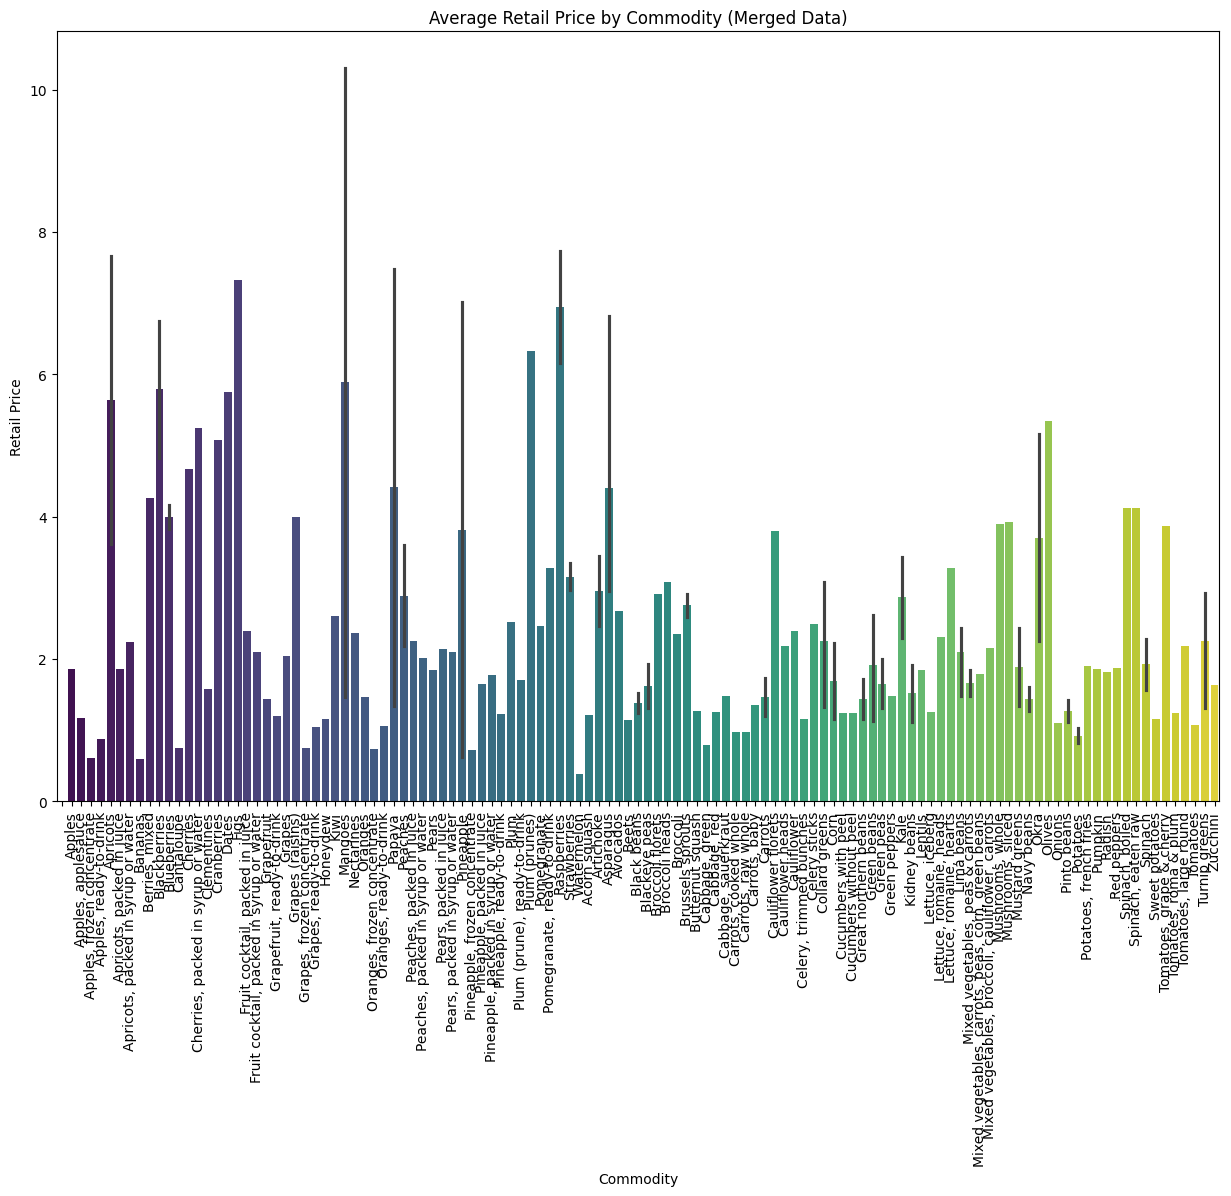

In [20]:
import pandas as pd
import sqlite3
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# File paths for the price datasets
fruit_prices_file = "Fruit-Prices-2022.csv"
vegetable_prices_file = "Vegetable-Prices-2022.csv"

# Error handling for csv file reading
try:
    fruit_df = pd.read_csv(fruit_prices_file)
    vegetable_df = pd.read_csv(vegetable_prices_file)
except FileNotFoundError as e:
    print(f"Error: {e.strerror}. Please check if the file path is correct.")
    exit()

# Display basic info about the CSV datasets
print("Fruit Prices Data:")
print(fruit_df.head())
print("\nVegetable Prices Data:")
print(vegetable_df.head())

# Summary for the ingested CSV data
print("\nIngested Fruit Prices Data Summary:")
print(f"Number of Records: {fruit_df.shape[0]}")
print(f"Number of Columns: {fruit_df.shape[1]}")

print("\nIngested Vegetable Prices Data Summary:")
print(f"Number of Records: {vegetable_df.shape[0]}")
print(f"Number of Columns: {vegetable_df.shape[1]}")

# Process the Fruit Prices CSV Data
if 'RetailPrice' in fruit_df.columns:
    average_fruit_price = fruit_df.groupby("Fruit")["RetailPrice"].mean()
    print("\nAverage Price by Fruit:")
    print(average_fruit_price)

# Process the Vegetable Prices CSV Data
if 'RetailPrice' in vegetable_df.columns:
    average_vegetable_price = vegetable_df.groupby("Vegetable")["RetailPrice"].mean()
    print("\nAverage Price by Vegetable:")
    print(average_vegetable_price)

# Quick Stats API setup for JSON data
API_KEY = ""  # put API key
API_URL = "https://quickstats.nass.usda.gov/api/api_GET/"
params = {
    "key": API_KEY,
    "commodity_desc": "APPLES",  # Use specific commodity
    "year": "2022",
    "source_desc": "SURVEY",  # Specify data source
    "sector_desc": "CROPS",  # specify sector
    "format": "JSON"
}

# Error handling for API request
try:
    response = requests.get(API_URL, params=params)
    if response.status_code == 200:
        api_data = response.json()
        if "data" in api_data:
            api_df = pd.DataFrame(api_data["data"])
            print("\nQuick Stats API Data:")
            print(api_df.head())
            # Perform analysis on API data here
            if 'RetailPrice' in api_df.columns:
                average_price_api = api_df.groupby("Commodity")["RetailPrice"].mean()
                print("\nAverage Price by Commodity (API Data):")
                print(average_price_api)
        else:
            print("API response is missing 'data' key.")
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        print("Response text:", response.text)
except requests.exceptions.RequestException as e:
    print(f"An error occurred while retrieving data from the API: {e}")
    exit()

# Separately save the CSV data to SQLite database
conn = sqlite3.connect("agriculture_data.db")

# Save Fruit Prices Data to SQLite
fruit_df.to_sql("fruit_prices", conn, if_exists="replace", index=False)
print("Fruit data successfully saved to SQLite database.")

# Save Vegetable Prices Data to SQLite
vegetable_df.to_sql("vegetable_prices", conn, if_exists="replace", index=False)
print("Vegetable data successfully saved to SQLite database.")

# Save API Data to SQLite
if 'api_df' in locals():
    api_df.to_sql("api_data", conn, if_exists="replace", index=False)
    print("API data successfully saved to SQLite database.")

conn.close()

# Merge Fruit and Vegetable Prices DataFrames (merge fruit and vegetable data separately)
merged_fruit_veg_df = pd.concat([fruit_df[['Fruit', 'RetailPrice']], vegetable_df[['Vegetable', 'RetailPrice']]], ignore_index=True)

# Merge the above result with API data (assuming 'Commodity' in API data matches 'Fruit' or 'Vegetable')
final_merged_df = pd.merge(merged_fruit_veg_df, api_df, how="outer", left_on="Fruit", right_on="class_desc", suffixes=('_fruit_veg', '_api'))

# Display merged data
print("\nMerged Data (Fruit, Vegetable, and API Data):")
print(final_merged_df.head())

# Create a 'Commodity' column combining fruit and vegetable data
final_merged_df['Commodity'] = final_merged_df['Fruit'].fillna('') + final_merged_df['Vegetable'].fillna('')

# Now plot using 'Commodity' as the x and hue axis
plt.figure(figsize=(12, 6))
sns.barplot(data=final_merged_df, x="Commodity", y="RetailPrice", hue="Commodity", palette="viridis", legend=False)
plt.title("Average Retail Price by Commodity (Merged Data)")
plt.xlabel("Commodity")
plt.ylabel("Average Retail Price")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


# Seaborn Visualizations

# Bar plot for average fruit prices
plt.figure(figsize=(12, 6))
sns.barplot(data=fruit_df, x="Fruit", y="RetailPrice", hue="Fruit", palette="viridis", legend=False)
plt.title("Average Retail Price of Fruits (2022)")
plt.xlabel("Fruit")
plt.ylabel("Retail Price (USD)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bar plot for average vegetable prices
plt.figure(figsize=(12, 6))
sns.barplot(data=vegetable_df, x="Vegetable", y="RetailPrice", hue="Vegetable", palette="viridis", legend=False)
plt.title("Average Retail Price of Vegetables (2022)")
plt.xlabel("Vegetable")
plt.ylabel("Retail Price (USD)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Scatter plot for API data (Yield vs. Retail Price)
if "Yield" in api_df.columns and "RetailPrice" in api_df.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=api_df, x="Yield", y="RetailPrice", hue="Commodity", palette="coolwarm", size="Yield", sizes=(50, 200), alpha=0.6, legend="brief")
    plt.title("Yield vs. Retail Price of Agricultural Commodities (2022)")
    plt.xlabel("Yield")
    plt.ylabel("Retail Price (USD)")
    plt.tight_layout()
    plt.show()

# Plotting after merging the data
plt.figure(figsize=(15, 10))  # Increase the size of the chart
sns.barplot(data=final_merged_df, x="Commodity", y="RetailPrice", hue="Commodity", palette="viridis", legend=False)
plt.xticks(rotation=90)  # Rotate labels
plt.title("Average Retail Price by Commodity (Merged Data)")
plt.xlabel("Commodity")
plt.ylabel("Retail Price")
plt.show()
